In [16]:
import scanpy as sc
import scarches as sch
import anndata as ad
import pandas as pd
import os
import numpy as np
import json
import scvi

import matplotlib.pyplot as plt

In [ ]:
path = "/Users/lukar818/Documents/postdoc/MCAR/data/visiumtwo" # set to location of glioblastoma data

In [3]:
with open(os.path.join(os.getcwd(), "..", "predids.json")) as json_file:
    json_data = json.load(json_file)

In [4]:
adata_all = sc.read_10x_mtx(
    os.path.join(path, "filtered_feature_bc_matrix"),
    var_names="gene_symbols",
    gex_only=False
)

In [5]:
json_data['glioblastoma'].keys()

dict_keys(['CR2', 'CD163', 'PCNA', 'BCL2', 'FCGR3A', 'EPCAM', 'CD40', 'CD4', 'CD274'])

## PCNA Glioblastoma example

In [6]:
test_barcodes = np.array(json_data['glioblastoma']['PCNA'])
mask_test = np.isin(adata_all.obs_names, test_barcodes)
mask_train = ~mask_test


In [7]:
sc.pp.highly_variable_genes(
    adata_all,
    flavor="seurat_v3",
    n_top_genes=4000,
    subset=True
)

In [ ]:
train_idx = np.where(mask_train)[0]
test_idx  = np.where(mask_test)[0]

rna = adata_all[:, adata_all.var["feature_types"] == "Gene Expression"]
prot = adata_all[:, adata_all.var["feature_types"] == "Antibody Capture"]

adata_train = ad.AnnData(
    X=rna.X[train_idx],
    obs=rna.obs.iloc[train_idx].copy(),
    var=rna.var.copy()
)
adata_train.obsm["protein_expression"] = prot.X[train_idx]
adata_train.uns["protein_names"] = prot.var_names.tolist()
adata_train.obs['batch'] = 'train'

adata_test = ad.AnnData(
    X=rna.X[test_idx],
    obs=rna.obs.iloc[test_idx].copy(),
    var=rna.var.copy()
)
adata_test.obsm["protein_expression"] = prot.X[test_idx]
adata_test.uns["protein_names"] = prot.var_names.tolist()
adata_test.obs['batch'] = 'test'

In [9]:
adata_train.X = adata_train.X.toarray() if hasattr(adata_train.X, "toarray") else adata_train.X

adata_train.obsm["protein_expression"] = (
    adata_train.obsm["protein_expression"].toarray()
    if hasattr(adata_train.obsm["protein_expression"], "toarray")
    else adata_train.obsm["protein_expression"]
)

In [11]:
adata_test.X = adata_test.X.toarray() if hasattr(adata_test.X, "toarray") else adata_test.X

adata_test.obsm["protein_expression"] = (
    adata_test.obsm["protein_expression"].toarray()
    if hasattr(adata_test.obsm["protein_expression"], "toarray")
    else adata_test.obsm["protein_expression"]
)

Glioblastoma and Visium10x breast cancer all has much larger protein expressions than the remaining datasets. It tends to cause converge issues across all methods.

In [12]:
for ads in [adata_train, adata_test]:
    prot = ads.obsm["protein_expression"]

    if hasattr(prot, "toarray"):
        prot = prot.toarray()
        
    prot = (prot / 100).astype(int)

    ads.obsm["protein_expression"] = prot

In [13]:
scvi.model.TOTALVI.setup_anndata(
    adata_train,
    protein_expression_obsm_key="protein_expression"
)

scvi.model.TOTALVI.setup_anndata(
    adata_test,
    protein_expression_obsm_key="protein_expression"
)

INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


/tmp/ipykernel_27796/4212774130.py:1: DeprecationWarning: We recommend using setup_mudata for multi-modal data.It does not influence model performance
  scvi.model.TOTALVI.setup_anndata(
/tmp/ipykernel_27796/4212774130.py:6: DeprecationWarning: We recommend using setup_mudata for multi-modal data.It does not influence model performance
  scvi.model.TOTALVI.setup_anndata(


In [14]:
vae_ref = sch.models.TOTALVI(
    adata_train,
    use_layer_norm="both",
    use_batch_norm="none"
)
vae_ref.train()

INFO     Computing empirical prior initialization for protein background.                                          


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/home/reinroth/Programming/anaconda3/envs/scarches/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
/home/reinroth/Programming/anaconda3/envs/scarches/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/home/reinr

Epoch 400/400: 100%|██████████| 400/400 [16:24<00:00,  2.38s/it, v_num=1, train_loss_step=4.06e+3, train_loss_epoch=4.13e+3]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [16:24<00:00,  2.46s/it, v_num=1, train_loss_step=4.06e+3, train_loss_epoch=4.13e+3]


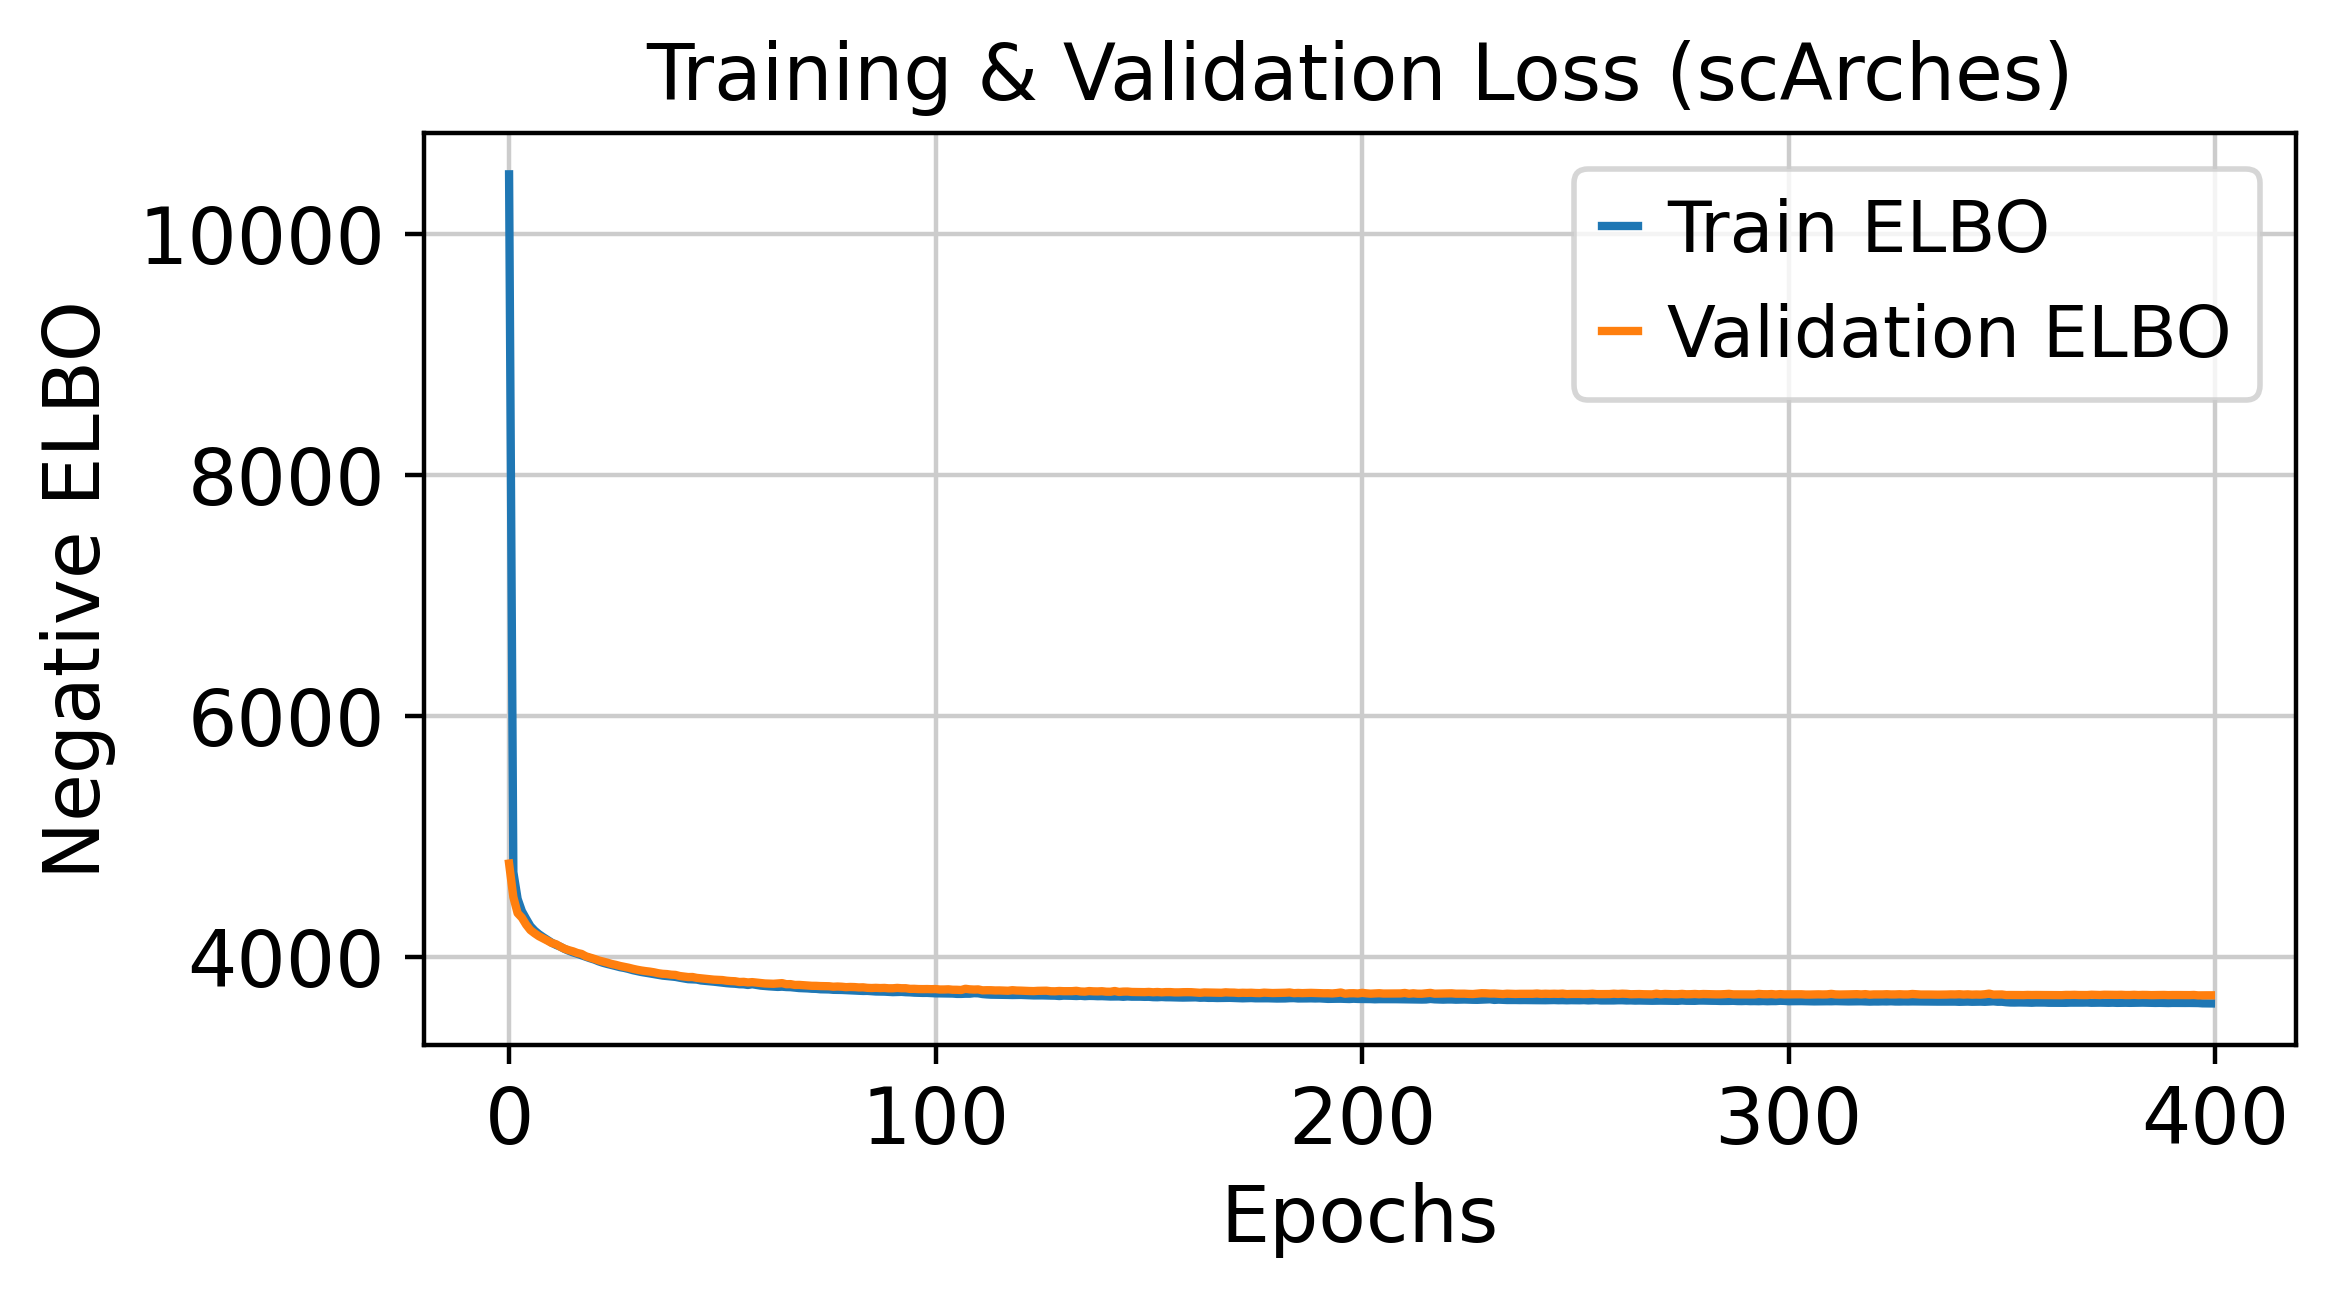

In [36]:
history = vae_ref.history_  # dictionary with keys like 'elbo_train', 'elbo_validation'

# plot ELBO loss
train_loss = history['elbo_train']
val_loss = history['elbo_validation']
plt.figure(figsize=(6, 3))
plt.plot(train_loss, label="Train ELBO")
plt.plot(val_loss, label="Validation ELBO")
plt.xlabel("Epochs")
plt.ylabel("Negative ELBO")
plt.legend()
plt.title("Training & Validation Loss (scArches)")
plt.show()

In [ ]:
true_proteins = adata_test.obsm["protein_expression"]

vae_ref.save("saved_model/", overwrite=True)

# Load pretrained model for fine-tuning
vae_q = sch.models.TOTALVI.load_query_data(
    adata_test,
    "saved_model/",
    freeze_expression=True
)
vae_q.train(200)

INFO     File saved_model/model.pt already downloaded                                                              
INFO     Computing empirical prior initialization for protein background.                                          


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/home/reinroth/Programming/anaconda3/envs/scarches/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
/home/reinroth/Programming/anaconda3/envs/scarches/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/home/reinr

Epoch 54/200:  27%|██▋       | 54/200 [00:06<00:16,  8.69it/s, v_num=1, train_loss_step=4.16e+3, train_loss_epoch=4.17e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 4162.615. Signaling Trainer to stop.


In [ ]:
true_proteins = adata_test.obsm["protein_expression"]

_, protein_pred = vae_q.get_normalized_expression(
    adata_test,
    n_samples=25,
    return_mean=True,
)

In [22]:
rmse_per_protein = np.sqrt(
    np.mean((true_proteins - protein_pred) ** 2, axis=0)
)

for prot_name, rmse_val in zip(adata_test.uns["protein_names"], rmse_per_protein):
    if prot_name == "PCNA-1":print(f"{prot_name}: {rmse_val:.2f}")

PCNA-1: 574.23


## PTPRC breast cancer (visium 10x) example

In [49]:
path = "/Users/lukar818/Documents/postdoc/MCAR/data/visiumbc" 
path = "/home/reinroth/Documents/lukas/postdoc/data/visiumbc"

adata_all = sc.read_10x_mtx(
    os.path.join(path, "filtered_feature_bc_matrix"),
    var_names="gene_symbols",
    gex_only=False
)

In [50]:
json_data['visiumBC'].keys()

dict_keys(['PCNA', 'VIM', 'KRT', 'PTPRC', 'PAX5', 'BCL2', 'CD19', 'FCGR3A', 'CD3E', 'PECAM1'])

In [51]:
sc.pp.highly_variable_genes(
    adata_all,
    flavor="seurat_v3",
    n_top_genes=4000,
    subset=True
)

In [52]:
test_barcodes = np.array(json_data['visiumBC']['PTPRC'])
mask_test = np.isin(adata_all.obs_names, test_barcodes)
mask_train = ~mask_test

train_idx = np.where(mask_train)[0]
test_idx  = np.where(mask_test)[0]

rna = adata_all[:, adata_all.var["feature_types"] == "Gene Expression"]
prot = adata_all[:, adata_all.var["feature_types"] == "Antibody Capture"]

adata_train = ad.AnnData(
    X=rna.X[train_idx],
    obs=rna.obs.iloc[train_idx].copy(),
    var=rna.var.copy()
)
adata_train.obsm["protein_expression"] = prot.X[train_idx]
adata_train.uns["protein_names"] = prot.var_names.tolist()
adata_train.obs['batch'] = 'train'

adata_test = ad.AnnData(
    X=rna.X[test_idx],
    obs=rna.obs.iloc[test_idx].copy(),
    var=rna.var.copy()
)
adata_test.obsm["protein_expression"] = prot.X[test_idx]
adata_test.uns["protein_names"] = prot.var_names.tolist()
adata_test.obs['batch'] = 'test'

In [53]:
for ads in [adata_train, adata_test]:
    prot = ads.obsm["protein_expression"]

    if hasattr(prot, "toarray"):
        prot = prot.toarray()
        
    prot = (prot / 100).astype(int)

    ads.obsm["protein_expression"] = prot

In [54]:
scvi.model.TOTALVI.setup_anndata(
    adata_train,
    protein_expression_obsm_key="protein_expression"
)

scvi.model.TOTALVI.setup_anndata(
    adata_test,
    protein_expression_obsm_key="protein_expression"
)

INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


/tmp/ipykernel_27796/4212774130.py:1: DeprecationWarning: We recommend using setup_mudata for multi-modal data.It does not influence model performance
  scvi.model.TOTALVI.setup_anndata(
/home/reinroth/Programming/anaconda3/envs/scarches/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/tmp/ipykernel_27796/4212774130.py:6: DeprecationWarning: We recommend using setup_mudata for multi-modal data.It does not influence model performance
  scvi.model.TOTALVI.setup_anndata(
/home/reinroth/Programming/anaconda3/envs/scarches/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_k

In [61]:
vae_ref = sch.models.TOTALVI(
    adata_train,
    use_layer_norm="both",
    use_batch_norm="none"
)
vae_ref.train()

INFO     Computing empirical prior initialization for protein background.                                          


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/home/reinroth/Programming/anaconda3/envs/scarches/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
/home/reinroth/Programming/anaconda3/envs/scarches/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/home/reinr

Epoch 400/400: 100%|██████████| 400/400 [15:28<00:00,  2.46s/it, v_num=1, train_loss_step=3.61e+3, train_loss_epoch=3.62e+3]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [15:28<00:00,  2.32s/it, v_num=1, train_loss_step=3.61e+3, train_loss_epoch=3.62e+3]


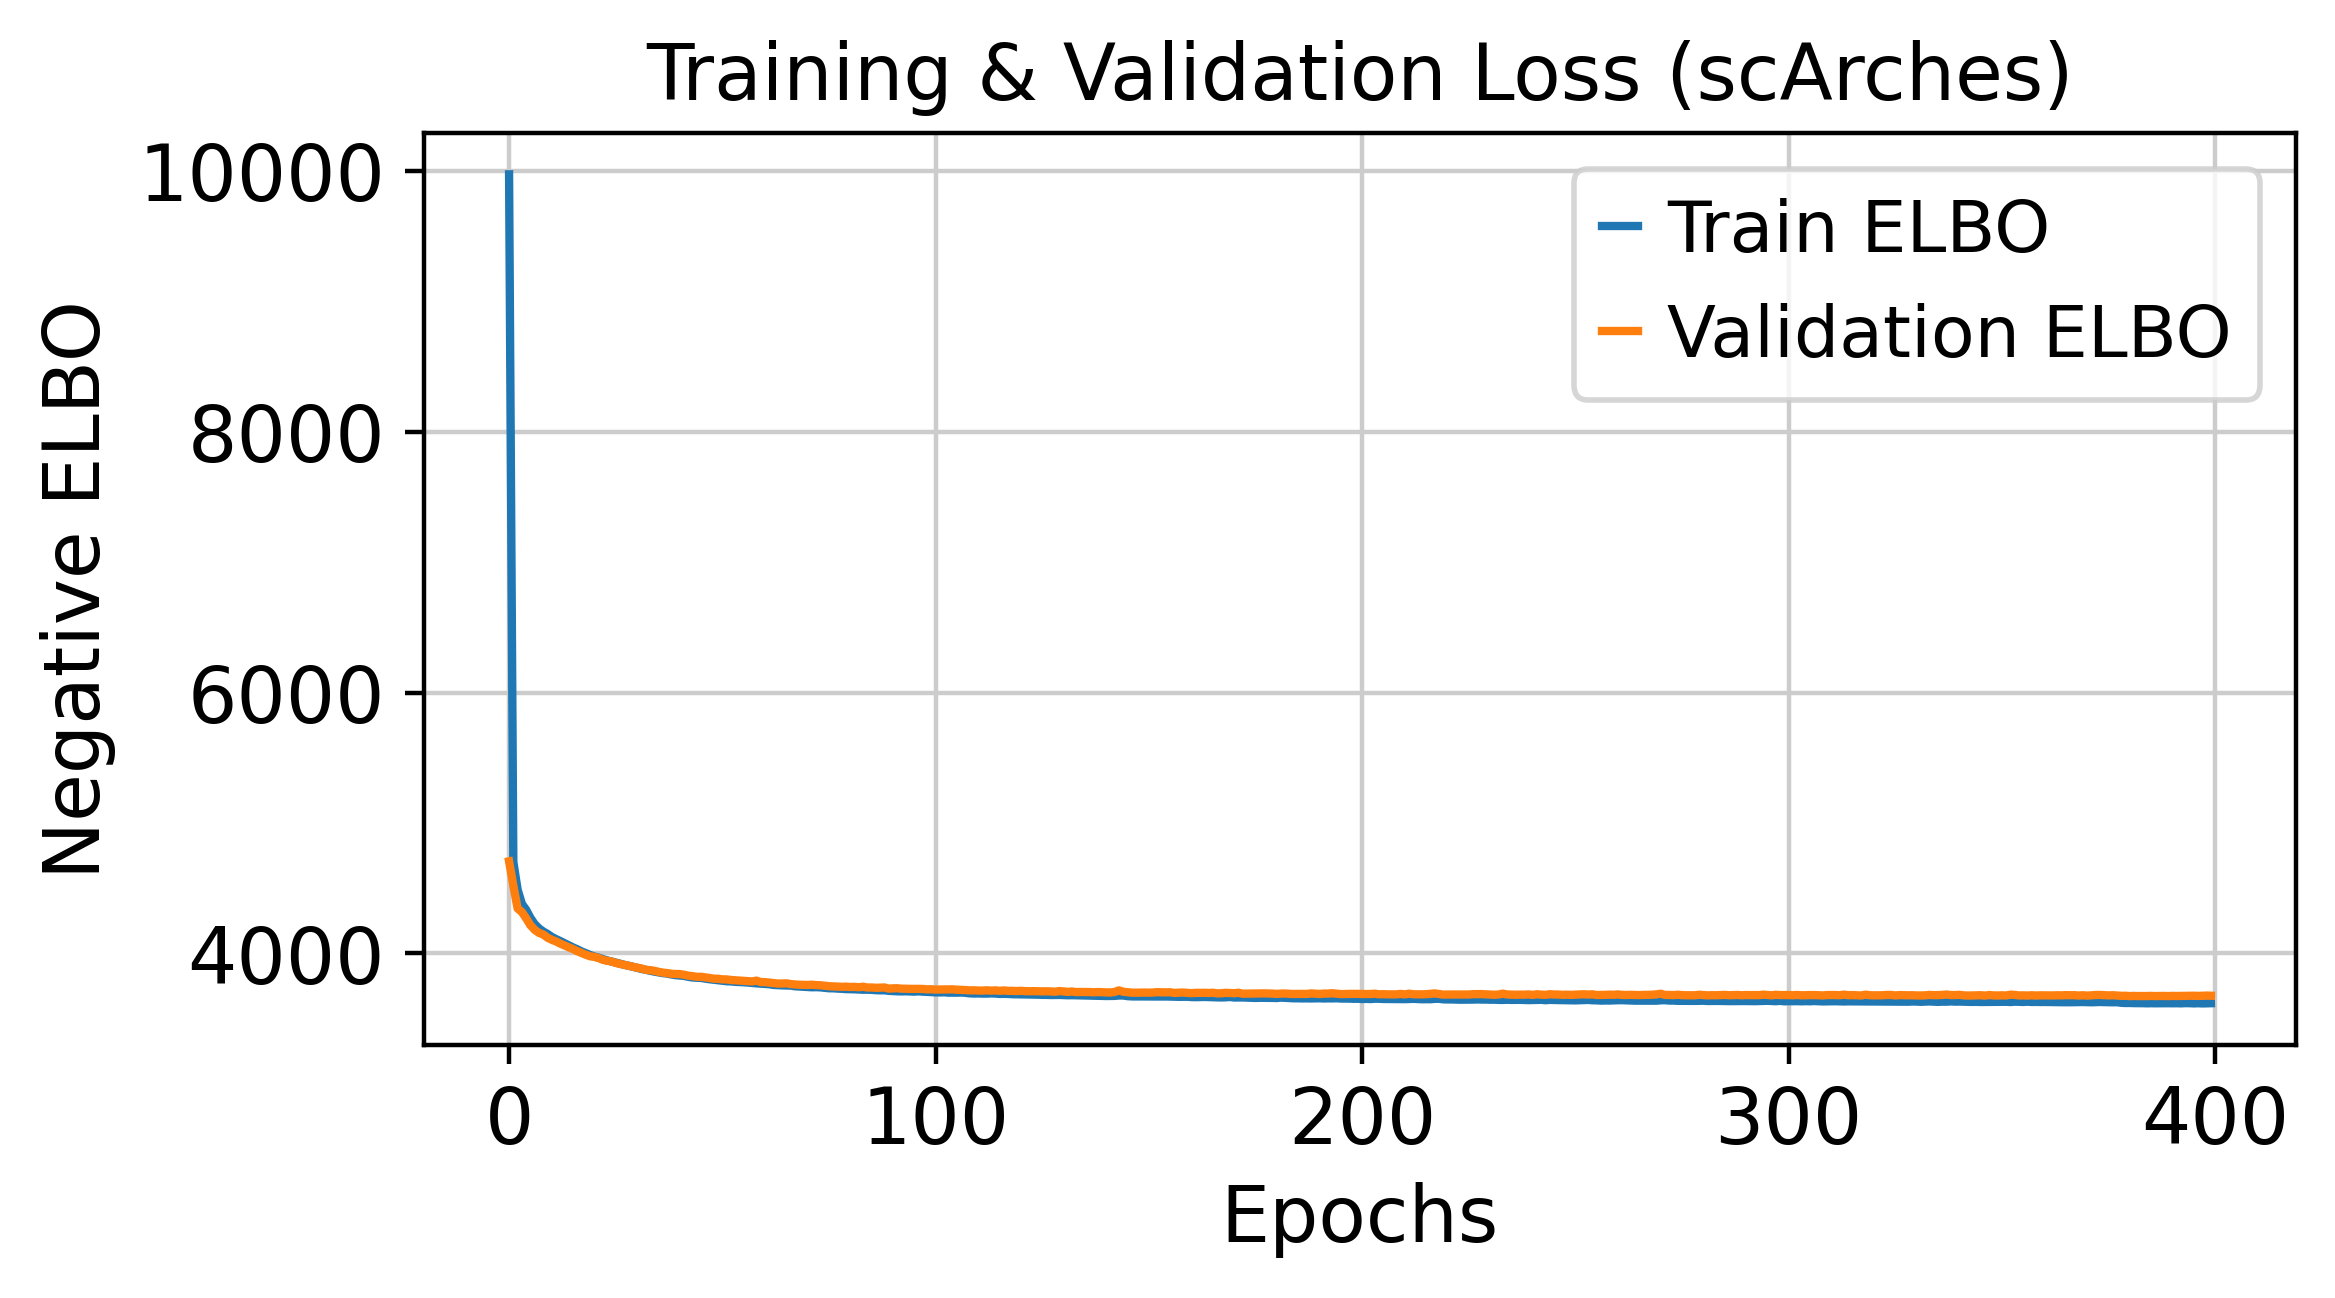

In [62]:
history = vae_ref.history_  # dictionary with keys like 'elbo_train', 'elbo_validation'

# plot ELBO loss
train_loss = history['elbo_train']
val_loss = history['elbo_validation']
plt.figure(figsize=(6, 3))
plt.plot(train_loss, label="Train ELBO")
plt.plot(val_loss, label="Validation ELBO")
plt.xlabel("Epochs")
plt.ylabel("Negative ELBO")
plt.legend()
plt.title("Training & Validation Loss (scArches)")
plt.show()

In [ ]:
vae_ref.save("saved_model/", overwrite=True)

# Load pretrained model for fine-tuning
vae_q = sch.models.TOTALVI.load_query_data(
    adata_test,
    "saved_model/",
    freeze_expression=True
)
vae_q.train(200)

INFO     File saved_model/model.pt already downloaded                                                              
INFO     Computing empirical prior initialization for protein background.                                          


/home/reinroth/Programming/anaconda3/envs/scarches/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/home/reinroth/Programming/anaconda3/envs/scarches/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:317: The lr scheduler dict contains the key(s) ['monitor'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
/home/reinroth/Programming/anaconda3/e

Epoch 78/200:  39%|███▉      | 78/200 [00:08<00:12,  9.39it/s, v_num=1, train_loss_step=2.91e+3, train_loss_epoch=2.93e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 3294.855. Signaling Trainer to stop.


In [65]:
true_proteins = adata_test.obsm["protein_expression"]

_, protein_pred = vae_q.get_normalized_expression(
    adata_test,
    n_samples=25,
    return_mean=True,
)

In [66]:
rmse_per_protein = np.sqrt(
    np.mean((true_proteins - protein_pred) ** 2, axis=0)
)

for prot_name, rmse_val in zip(adata_test.uns["protein_names"], rmse_per_protein):
    if prot_name == "PTPRC-2":print(f"{prot_name}: {rmse_val:.2f}")

PTPRC-2: 424.27
